# Disease Symptoms Prediction Model

## Introduction:

The primary objective is to use the symptoms data to predict the associated disease using a classification model. By understanding the correlation between symptoms and diseases, healthcare professionals can make more informed decisions and provide timely intervention.

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from itertools import chain
from nltk.util import ngrams
from collections import Counter
from sklearn.utils import resample
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

## Acquire

## Prepare:

#### Dataset Structure:

- **Rows**: 4920
- **Columns**: 18
- **Columns**: Disease, Symptom

## Dataset 2

In [33]:
df = pd.read_csv('dataset.csv')

In [34]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(4920, 18)

In [5]:
# Convert symptom columns to string type for consistent data type
df[df.columns[1:]] = df[df.columns[1:]].astype(str)

# One-hot encode each symptom column and aggregate the result to remove duplicates
encoded_list = [pd.get_dummies(df[col], prefix="", prefix_sep="") for col in df.columns[1:]]
encoded_df = pd.concat(encoded_list, axis=1)
encoded_df = encoded_df.groupby(encoded_df.columns, axis=1).sum().clip(upper=1)

# Concatenate the Disease column with the aggregated symptoms
df_final = pd.concat([df["Disease"], encoded_df], axis=1)
# Replace any string 'nan' or NaN values with genuine NaN
df_final = df_final.drop(columns='nan')

df_final.shape

(4920, 132)

In [6]:
df_final.head()

,Disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Explore

In [7]:
# For binary/multi-class classification
train, temp = train_test_split(df_final, test_size=0.4, stratify=df_final['Disease'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['Disease'], random_state=42)
train.shape, val.shape, test.shape

((2952, 132), (984, 132), (984, 132))

# Split the data into training, validation, and testing sets
# First, we split the data into training (60%) and temporary (40%)
train, temp = train_test_split(df_final, test_size=0.3, random_state=42)

# Now, split the temporary set into validation (20%) and test sets (20%)
val, test = train_test_split(temp, test_size=0.5, random_state=42)
train.shape, val.shape, test.shape

In [8]:
df['Disease'].value_counts()

Disease
Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
Aller

**Question 1:** What is the distribution of diseases in the dataset?

**Visualization:** Create a bar plot of the disease occurrences.

 ### Bar Chart of top 10 Disease Count

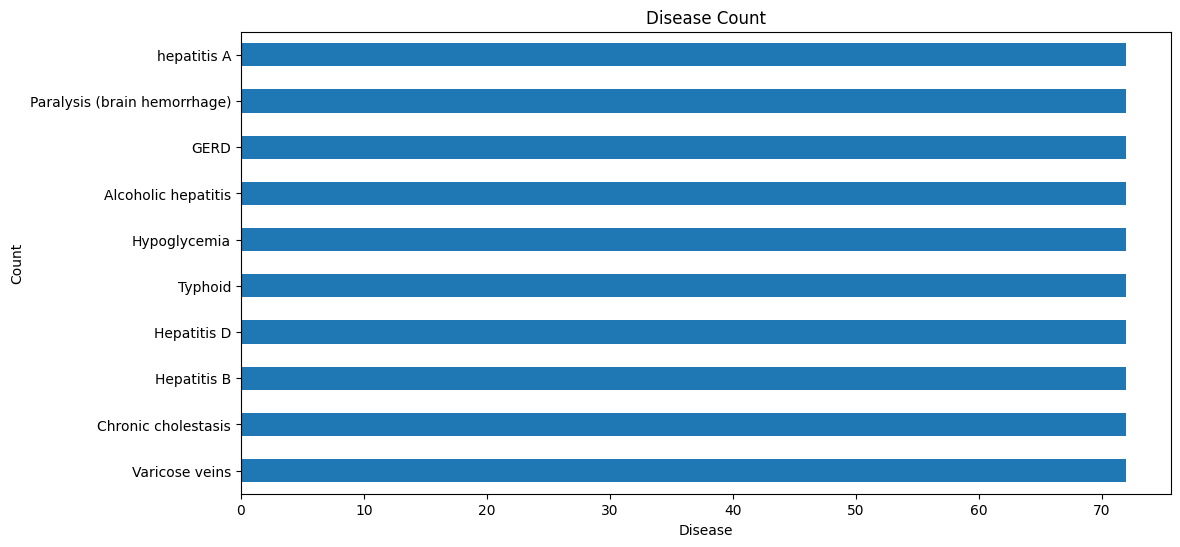

In [9]:
disease_counts = train['Disease'].value_counts().tail(10)
disease_counts.plot(kind='barh', figsize=(12, 6))
plt.title("Disease Count")
plt.ylabel("Count")
plt.xlabel("Disease")
plt.show()

### Top 20 Symptom Frequency Bar Chart

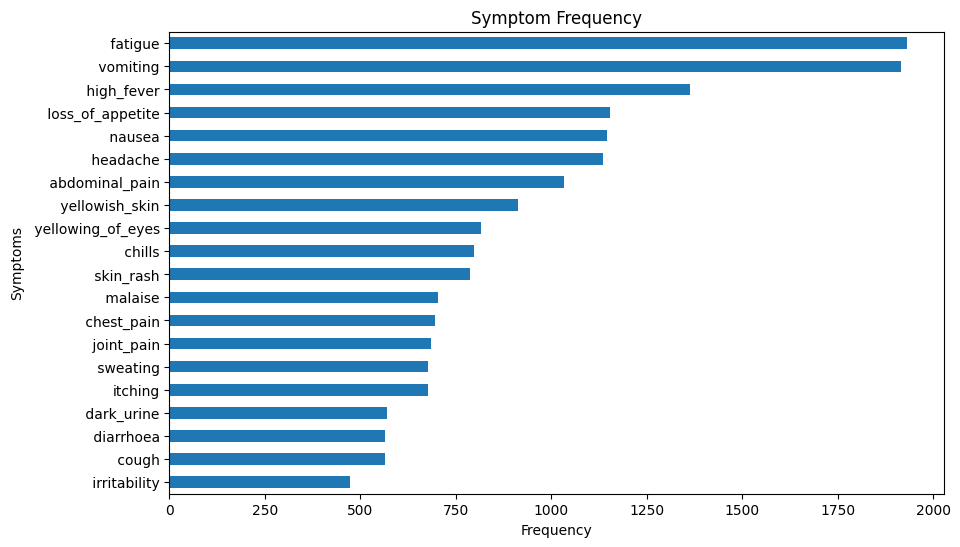

In [10]:
# Exclude 'Disease' column and sum occurrences of each symptom, excluding NaN values
symptom_counts = df_final.drop(columns='Disease').apply(lambda x: x.value_counts().get(1, 0))

# Sort the symptoms based on their frequency and plot the top ones
plt.figure(figsize=(10, 6))
symptom_counts.sort_values(ascending=True).tail(20).plot(kind='barh')
plt.title("Symptom Frequency")
plt.xlabel("Frequency")
plt.ylabel("Symptoms")
plt.show()

### Word Cloud

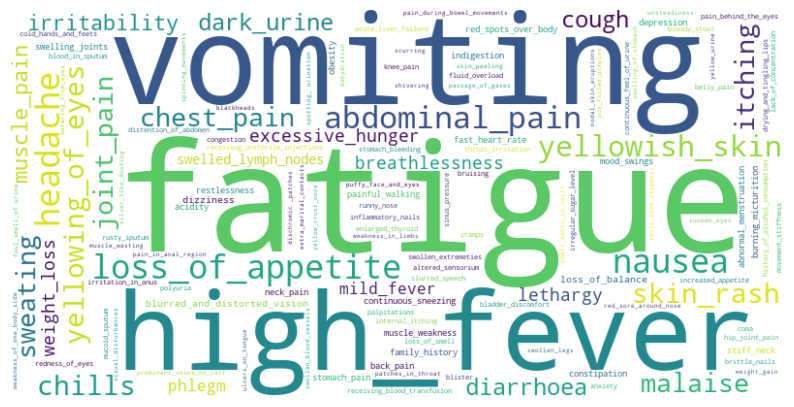

In [11]:
# Generate the word cloud using the symptom counts
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(symptom_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

N-GRAMS

In [12]:
# Drop the 'Disease' column and flatten the DataFrame to get a list of all symptom words
all_symptoms = df.drop(columns=['Disease']).values.flatten()
# Convert all values to strings and filter out the string representation of NaN
all_symptoms = [str(s) for s in all_symptoms if str(s) != 'nan' and str(s) != 'NaN']


# Tokenize the symptoms
tokens = list(chain.from_iterable([symptom.split('_') for symptom in all_symptoms]))

# Generate bi-grams and tri-grams
bi_grams = list(ngrams(tokens, 2))
tri_grams = list(ngrams(tokens, 3))

# Count frequencies of each bi-gram and tri-gram
bi_gram_counts = Counter(bi_grams)
tri_gram_counts = Counter(tri_grams)

#### Bi-Grams

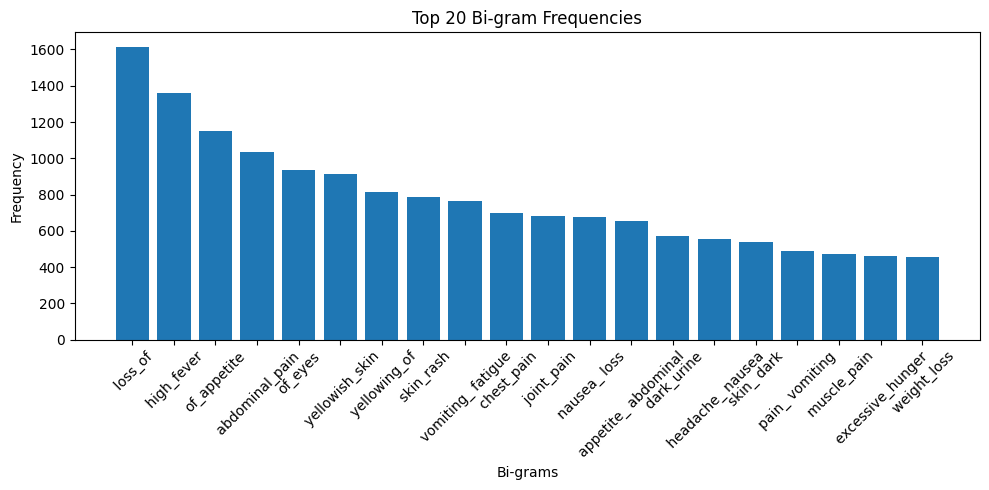

In [13]:
# Sort the bi_gram_counts dictionary by values (frequencies) in descending order and take top 20
top_20_bi_grams = dict(sorted(bi_gram_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Visualization of Top 20 Bi-grams
plt.figure(figsize=(10, 5))
plt.bar(['_'.join(bg) for bg in top_20_bi_grams.keys()], top_20_bi_grams.values())
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Bi-gram Frequencies')
plt.tight_layout()
plt.show()

#### Tri-Grams

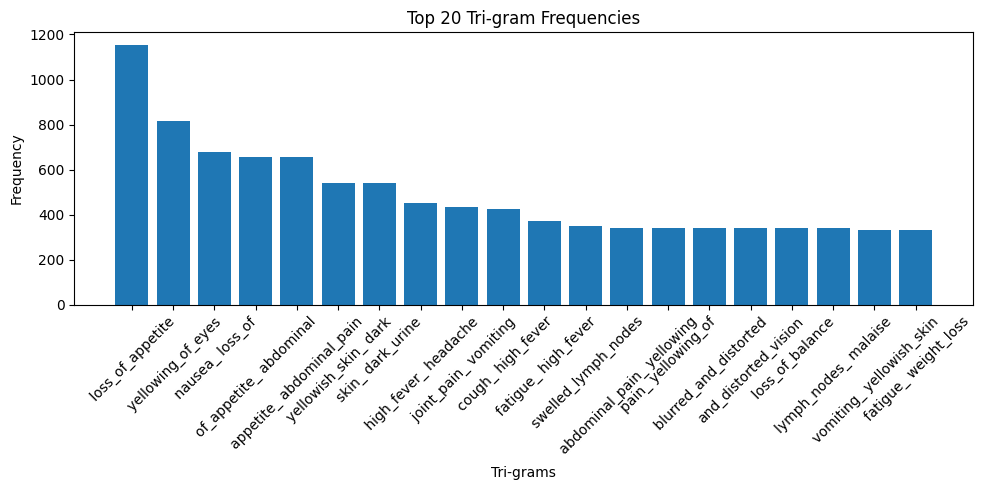

In [14]:
# Sort the tri_gram_counts dictionary by values (frequencies) in descending order and take top 20
top_20_tri_grams = dict(sorted(tri_gram_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Visualization of Top 20 Tri-grams
plt.figure(figsize=(10, 5))
plt.bar(['_'.join(tg) for tg in top_20_tri_grams.keys()], top_20_tri_grams.values())
plt.xlabel('Tri-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Tri-gram Frequencies')
plt.tight_layout()
plt.show()

## Modeling

In [16]:
df_final.head()

,Disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Data split

In [17]:
# X_train and y_train split
X_train = train.drop('Disease', axis=1)
y_train = train['Disease']

# X_val and y_val split
X_val = val.drop('Disease', axis=1)
y_val = val['Disease']

# X_test and y_test split
X_test = test.drop('Disease', axis=1)
y_test = test['Disease']

In [18]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2952, 131), (984, 131), (2952,), (984,))

In [19]:
# Create a dummy classifier that always predicts the class that maximizes the training set's class distribution
dummy_clf = DummyClassifier(strategy="most_frequent")

# Fit the classifier
dummy_clf.fit(X_train, y_train)

# Predict on the test set
baseline_predictions = dummy_clf.predict(X_val)

# Calculate the accuracy
baseline_accuracy = accuracy_score(y_val, baseline_predictions)

baseline_accuracy

0.024390243902439025

In [20]:
clf = RandomForestClassifier(random_state=42)

In [21]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_val)
accuracy_score(y_val, y_pred)

1.0

In [24]:
# Initialize and train the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict on test set
log_reg_preds = log_reg.predict(X_val)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_val, log_reg_preds)
log_reg_accuracy

1.0

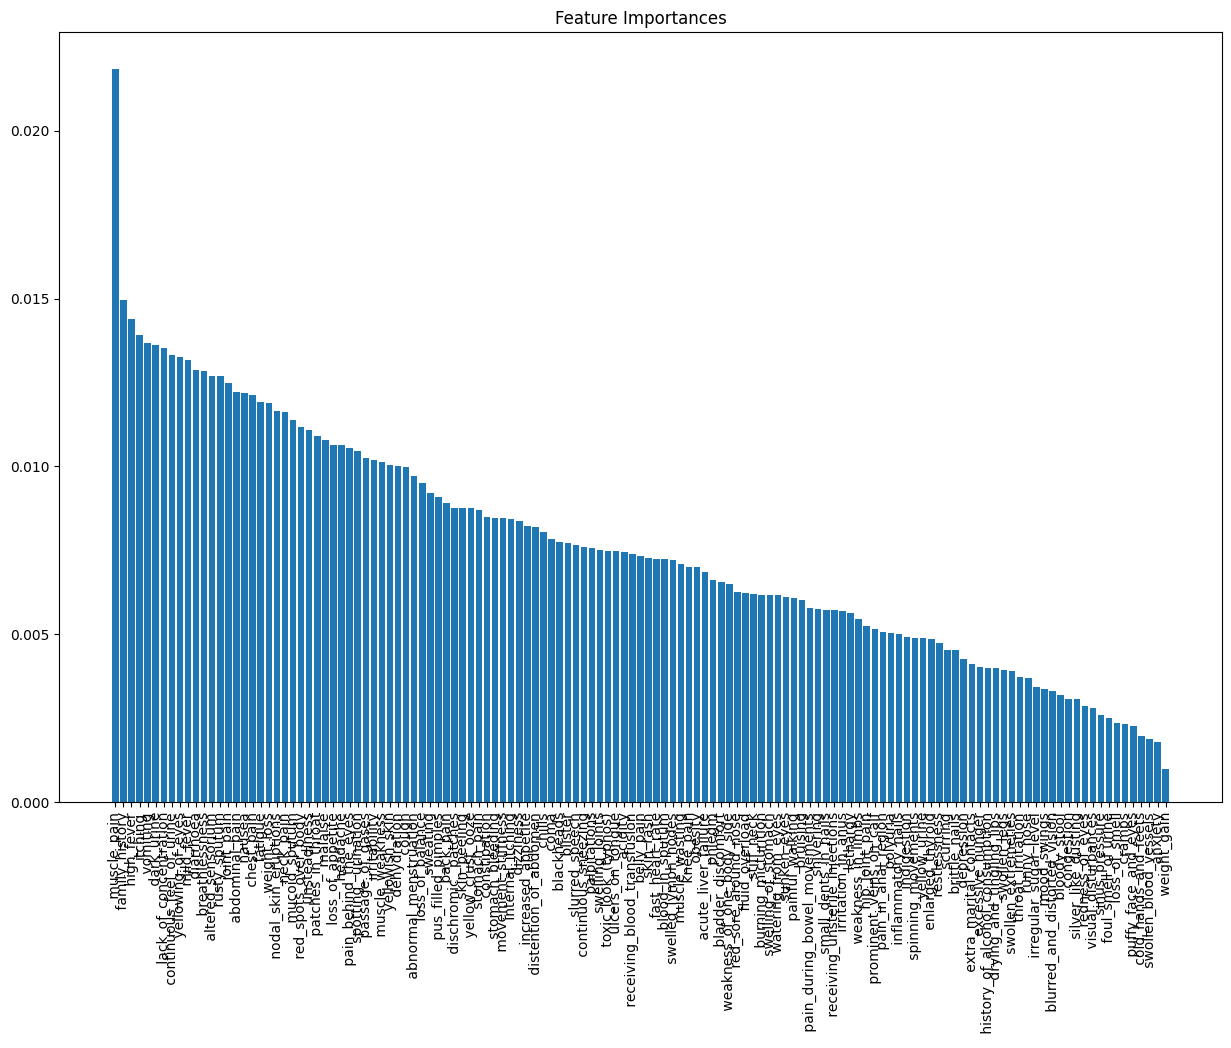

In [25]:
importances = clf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 10))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.show()

In [35]:
# Melt the dataframe
df = df.melt(id_vars=['Disease'], value_name='Symptom')

# Remove rows with NaN values in the Symptom column
df.dropna(subset=['Symptom'], inplace=True)

# Drop the variable column as it's not needed
df.drop(columns=['variable'], inplace=True)
df.head()

,Disease,Symptom
0,Fungal infection,itching
1,Fungal infection,skin_rash
2,Fungal infection,itching
3,Fungal infection,itching
4,Fungal infection,itching


In [37]:
# Label Encoding
label_encoders = {}

# Encoding 'Disease'
disease_encoder = LabelEncoder()
df['Disease_encoded'] = disease_encoder.fit_transform(df['Disease'])
label_encoders['Disease'] = disease_encoder

In [38]:
# Encoding 'Symptom'
symptom_encoder = LabelEncoder()
df['Symptom_encoded'] = symptom_encoder.fit_transform(df['Symptom'])
label_encoders['Symptom'] = symptom_encoder

# Checking distribution of 'Disease' for balancing
disease_counts = df['Disease_encoded'].value_counts()

In [39]:
# Identify the majority class
majority_class = disease_counts.idxmax()

# Separate majority and minority classes
df_majority = df[df.Disease_encoded == majority_class]
df_minority = df[df.Disease_encoded != majority_class]

In [41]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=disease_counts[majority_class],
                                 random_state=42) 

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Display the balanced dataset distribution
print(df_balanced['Disease_encoded'].value_counts().head())

Disease_encoded
10    1992
36     107
25     100
11      95
19      94
Name: count, dtype: int64


In [42]:
# Identify the majority class count
majority_count = df['Disease_encoded'].value_counts().max()

In [43]:
# Separate data by Disease_encoded and upsample each minority class
dfs = []
for disease_code in df['Disease_encoded'].unique():
    disease_df = df[df['Disease_encoded'] == disease_code]
    resampled_df = resample(disease_df, 
                            replace=True, 
                            n_samples=majority_count, 
                            random_state=42)
    dfs.append(resampled_df)

In [44]:
# Concatenate the upsampled dfs
df_balanced = pd.concat(dfs)

# Display the balanced dataset distribution
print(df_balanced['Disease_encoded'].value_counts().head())

Disease_encoded
15    1992
20    1992
22    1992
3     1992
36    1992
Name: count, dtype: int64


In [56]:
# Encode the 'Symptom' column
encoder_symptom = LabelEncoder()
df['Symptom_encoded'] = encoder_symptom.fit_transform(df['Symptom'])

# Splitting the data again
X = df.drop(['Disease', 'Symptom', 'Disease_encoded'], axis=1)  # Using only 'Symptom_encoded' as features
y = df['Disease_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Create a dummy classifier that always predicts the class that maximizes the training set's class distribution
dummy_clf = DummyClassifier(strategy="most_frequent")

# Fit the classifier
dummy_clf.fit(X_train, y_train)

# Predict on the test set
baseline_predictions = dummy_clf.predict(X_test)

# Calculate the accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

baseline_accuracy

0.05579809004092769

In [59]:
# Initialize and train the model
log_reg = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence
log_reg.fit(X_train, y_train)

# Predict on test set
log_reg_preds = log_reg.predict(X_test)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
log_reg_accuracy

0.05757162346521146

In [60]:
# Initialize and train the model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on test set
decision_tree_preds = decision_tree.predict(X_test)

# Evaluate the model
decision_tree_accuracy = accuracy_score(y_test, decision_tree_preds)
decision_tree_accuracy

0.3813096862210095

In [61]:
# Initialize and train the model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Predict on test set
random_forest_preds = random_forest.predict(X_test)

# Evaluate the model
random_forest_accuracy = accuracy_score(y_test, random_forest_preds)
random_forest_accuracy

0.3814461118690314

In [62]:
# Initialize and train the model
knn = KNeighborsClassifier(n_neighbors=5)  # Default number of neighbors is 5
knn.fit(X_train, y_train)

# Predict on test set
knn_preds = knn.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, knn_preds)
knn_accuracy

0.40641200545702594